Kaggle code: https://www.kaggle.com/code/fareselmenshawii/linear-regression-from-scratch

#Setting up the provenance file

In [1]:
!pip install yprov4ml

In [2]:
import pandas as pd
import matplotlib
import torch
import sklearn
import networkx
import prov
import tqdm
import numpy as np
import yprov4ml
import math
import plotly.express as px
import pickle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Start the provenance run
yprov4ml.start_run(
    prov_user_namespace="www.example.og",
    experiment_name="linear_regression",
    provenance_save_dir="/content/"
)

#Training

In [ ]:
# Load the training and test datasets
train_data = pd.read_csv('/save/path/linear_regression_train.csv')
test_data = pd.read_csv('/save/path/linear_regression_test.csv')

# Save the datasets as provenance
yprov4ml.log_dataset(train_data, "train_data")
yprov4ml.log_dataset(test_data, "test_data")

In [8]:
# Remove rows with missing values
train_data = train_data.dropna()
test_data = test_data.dropna()

# Save the preprocessing step as provenance
yprov4ml.log_param("dropna_training_data_cleanup", train_data)
yprov4ml.log_param("dropna_testing_data_cleanup", test_data)

In [9]:
train_data.head()

,x,y
0,24.0,21.549452
1,50.0,47.464463
2,15.0,17.218656
3,38.0,36.586398
4,87.0,87.288984


In [10]:
px.scatter(x=train_data['x'], y=train_data['y'],template='seaborn')

In [11]:
# Set training data and target
X_train = train_data['x'].values
y_train = train_data['y'].values

# Set testing data and target
X_test = test_data['x'].values
y_test = test_data['y'].values

In [12]:
def standardize_data(X_train, X_test):
    """
    Standardizes the input data using mean and standard deviation.

    Parameters:
        X_train (numpy.ndarray): Training data.
        X_test (numpy.ndarray): Testing data.

    Returns:
        Tuple of standardized training and testing data.
    """
    # Calculate the mean and standard deviation using the training data
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)

    # Standardize the data
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std

    return X_train, X_test

X_train, X_test = standardize_data(X_train, X_test)

#Save the preprocessing step as provenance
yprov4ml.log_param("standardize_training_data", X_train)
yprov4ml.log_param("standardize_testing_data", X_test)

In [13]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

#Save the preprocessing step as provenance
yprov4ml.log_param("expand_dims_training_data", X_train)
yprov4ml.log_param("expand_dims_testing_data", X_test)

In [14]:
class LinearRegression:
    """
    Linear Regression Model with Gradient Descent

    Linear regression is a supervised machine learning algorithm used for modeling the relationship
    between a dependent variable (target) and one or more independent variables (features) by fitting
    a linear equation to the observed data.

    This class implements a linear regression model using gradient descent optimization for training.
    It provides methods for model initialization, training, prediction, and model persistence.

    Parameters:
        learning_rate (float): The learning rate used in gradient descent.
        convergence_tol (float, optional): The tolerance for convergence (stopping criterion). Defaults to 1e-6.

    Attributes:
        W (numpy.ndarray): Coefficients (weights) for the linear regression model.
        b (float): Intercept (bias) for the linear regression model.

    Methods:
        initialize_parameters(n_features): Initialize model parameters.
        forward(X): Compute the forward pass of the linear regression model.
        compute_cost(predictions): Compute the mean squared error cost.
        backward(predictions): Compute gradients for model parameters.
        fit(X, y, iterations, plot_cost=True): Fit the linear regression model to training data.
        predict(X): Predict target values for new input data.
        save_model(filename=None): Save the trained model to a file using pickle.
        load_model(filename): Load a trained model from a file using pickle.

    Examples:
        >>> from linear_regression import LinearRegression
        >>> model = LinearRegression(learning_rate=0.01)
        >>> model.fit(X_train, y_train, iterations=1000)
        >>> predictions = model.predict(X_test)
    """

    def __init__(self, learning_rate, convergence_tol=1e-6):
        self.learning_rate = learning_rate
        self.convergence_tol = convergence_tol
        self.W = None
        self.b = None
        self.function = None

    def initialize_parameters(self, n_features):
        """
        Initialize model parameters.

        Parameters:
            n_features (int): The number of features in the input data.
        """
        self.W = np.random.randn(n_features) * 0.01
        self.b = 0

    def forward(self, X):
        """
        Compute the forward pass of the linear regression model.

        Parameters:
            X (numpy.ndarray): Input data of shape (m, n_features).

        Returns:
            numpy.ndarray: Predictions of shape (m,).
        """
        return np.dot(X, self.W) + self.b

    def compute_cost(self, predictions):
        """
        Compute the mean squared error cost.

        Parameters:
            predictions (numpy.ndarray): Predictions of shape (m,).

        Returns:
            float: Mean squared error cost.
        """
        m = len(predictions)
        cost = np.sum(np.square(predictions - self.y)) / (2 * m)
        return cost

    def backward(self, predictions):
        """
        Compute gradients for model parameters.

        Parameters:
            predictions (numpy.ndarray): Predictions of shape (m,).

        Updates:
            numpy.ndarray: Gradient of W.
            float: Gradient of b.
        """
        m = len(predictions)
        self.dW = np.dot(predictions - self.y, self.X) / m
        self.db = np.sum(predictions - self.y) / m

    def equation(self, feature_names=None, precision=6):
      """
      Return a human-readable equation of the learned linear function.
      """
      assert self.W is not None, "Call fit() before getting the equation."
      if feature_names is None:
          feature_names = [f"x{i+1}" for i in range(len(self.W))]
      terms = [f"{self.W[i]:.{precision}f}*{feature_names[i]}" for i in range(len(self.W))]
      return "ŷ = " + " + ".join(terms) + f" + {self.b:.{precision}f}"

    def fit(self, X, y, iterations, plot_cost=True):
        """
        Fit the linear regression model to the training data.

        Parameters:
            X (numpy.ndarray): Training input data of shape (m, n_features).
            y (numpy.ndarray): Training labels of shape (m,).
            iterations (int): The number of iterations for gradient descent.
            plot_cost (bool, optional): Whether to plot the cost during training. Defaults to True.

        Raises:
            AssertionError: If input data and labels are not NumPy arrays or have mismatched shapes.

        Plots:
            Plotly line chart showing cost vs. iteration (if plot_cost is True).
        """
        assert isinstance(X, np.ndarray), "X must be a NumPy array"
        assert isinstance(y, np.ndarray), "y must be a NumPy array"
        assert X.shape[0] == y.shape[0], "X and y must have the same number of samples"
        assert iterations > 0, "Iterations must be greater than 0"

        self.X = X
        self.y = y
        self.initialize_parameters(X.shape[1])
        costs = []

        for i in range(iterations):
            predictions = self.forward(X)
            cost = self.compute_cost(predictions)
            self.backward(predictions)
            self.W -= self.learning_rate * self.dW
            self.b -= self.learning_rate * self.db
            costs.append(cost)

            if i % 100 == 0:
                print(f'Iteration: {i}, Cost: {cost}')

            if i > 0 and abs(costs[-1] - costs[-2]) < self.convergence_tol:
                print(f'Converged after {i} iterations.')
                break

        if plot_cost:
            fig = px.line(y=costs, title="Cost vs Iteration", template="plotly_dark")
            fig.update_layout(
                title_font_color="#41BEE9",
                xaxis=dict(color="#41BEE9", title="Iterations"),
                yaxis=dict(color="#41BEE9", title="Cost")
            )

            fig.show()

            # save function to provenance data
            self.function = self.equation()


    def predict(self, X):
        """
        Predict target values for new input data.

        Parameters:
            X (numpy.ndarray): Input data of shape (m, n_features).

        Returns:
            numpy.ndarray: Predicted target values of shape (m,).
        """
        return self.forward(X)


    def save_model(self, filename=None):
        """
        Save the trained model to a file using pickle.

        Parameters:
            filename (str): The name of the file to save the model to.
        """
        model_data = {
            'learning_rate': self.learning_rate,
            'convergence_tol': self.convergence_tol,
            'W': self.W,
            'b': self.b
        }

        with open(filename, 'wb') as file:
            pickle.dump(model_data, file)

    @classmethod
    def load_model(cls, filename):
        """
        Load a trained model from a file using pickle.

        Parameters:
            filename (str): The name of the file to load the model from.

        Returns:
            LinearRegression: An instance of the LinearRegression class with loaded parameters.
        """
        with open(filename, 'rb') as file:
            model_data = pickle.load(file)

        # Create a new instance of the class and initialize it with the loaded parameters
        loaded_model = cls(model_data['learning_rate'], model_data['convergence_tol'])
        loaded_model.W = model_data['W']
        loaded_model.b = model_data['b']

        return loaded_model

In [15]:
lr = LinearRegression(0.01)
lr.fit(X_train, y_train, 10000)

Iteration: 0, Cost: 1670.0874033674047
Iteration: 100, Cost: 227.1645841777389
Iteration: 200, Cost: 33.84225401757371
Iteration: 300, Cost: 7.940991079931172
Iteration: 400, Cost: 4.470748293135241
Iteration: 500, Cost: 4.005806292882129
Iteration: 600, Cost: 3.943513514860407
Iteration: 700, Cost: 3.9351675487150577
Iteration: 800, Cost: 3.9340493588845287
Converged after 863 iterations.


In [16]:
lr.save_model('model.pkl')
yprov4ml.log_artifact(lr.function, "model.pkl")

<ProvEntity: model.pkl>

In [ ]:
# End run
yprov4ml.end_run(create_graph=True, create_svg=True)

In [21]:
!apt-get -qq install graphviz
!pip install graphviz


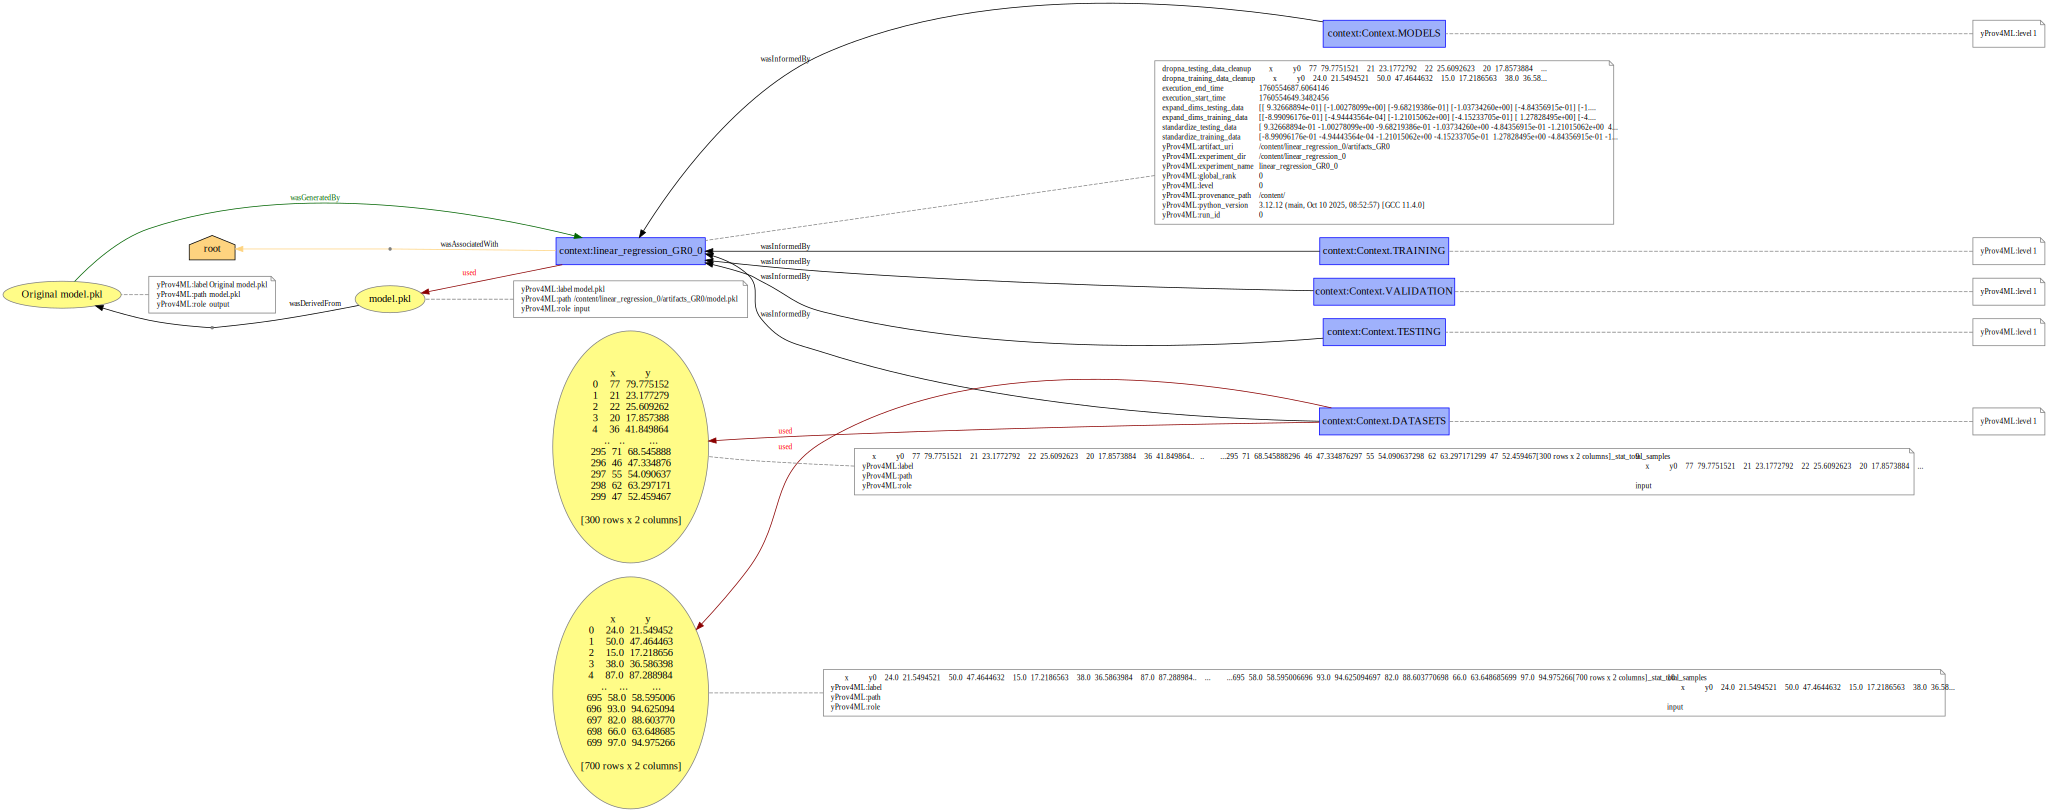

'prov_graph.png'

In [ ]:
import graphviz
from IPython.display import SVG, display

filename = "/save/path/prov_linear_regression_GR0_0.dot"

# Read the content of the .dot file
with open(filename, 'r') as f:
    dot_content = f.read()

# Create a Graphviz object from the .dot content
graph = graphviz.Source(dot_content)

# Render the graph to SVG and display it
display(SVG(graph.pipe(format='svg')))

graph.render(filename='prov_graph', format='png', cleanup=True)

#Evaluation

In [ ]:
model = LinearRegression.load_model("model.pkl")

In [ ]:
class RegressionMetrics:
    @staticmethod
    def mean_squared_error(y_true, y_pred):
        """
        Calculate the Mean Squared Error (MSE).

        Args:
            y_true (numpy.ndarray): The true target values.
            y_pred (numpy.ndarray): The predicted target values.

        Returns:
            float: The Mean Squared Error.
        """
        assert len(y_true) == len(y_pred), "Input arrays must have the same length."
        mse = np.mean((y_true - y_pred) ** 2)
        return mse

    @staticmethod
    def root_mean_squared_error(y_true, y_pred):
        """
        Calculate the Root Mean Squared Error (RMSE).

        Args:
            y_true (numpy.ndarray): The true target values.
            y_pred (numpy.ndarray): The predicted target values.

        Returns:
            float: The Root Mean Squared Error.
        """
        assert len(y_true) == len(y_pred), "Input arrays must have the same length."
        mse = RegressionMetrics.mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        return rmse

    @staticmethod
    def r_squared(y_true, y_pred):
        """
        Calculate the R-squared (R^2) coefficient of determination.

        Args:
            y_true (numpy.ndarray): The true target values.
            y_pred (numpy.ndarray): The predicted target values.

        Returns:
            float: The R-squared (R^2) value.
        """
        assert len(y_true) == len(y_pred), "Input arrays must have the same length."
        mean_y = np.mean(y_true)
        ss_total = np.sum((y_true - mean_y) ** 2)
        ss_residual = np.sum((y_true - y_pred) ** 2)
        r2 = 1 - (ss_residual / ss_total)
        return r2


In [ ]:
y_pred = model.predict(X_test)
mse_value = RegressionMetrics.mean_squared_error(y_test, y_pred)
rmse_value = RegressionMetrics.root_mean_squared_error(y_test, y_pred)
r_squared_value = RegressionMetrics.r_squared(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse_value}")
print(f"Root Mean Squared Error (RMSE): {rmse_value}")
print(f"R-squared (Coefficient of Determination): {r_squared_value}")